## Project Overview
A predictive model based analysis of electric rental bikes and how far away from any given docking station people are locking them up.

This notebook mirrors the README but with associated code

### Data Source
This data comes from public sources:

The San Francisco Bay Wheels bike share [data](https://s3.amazonaws.com/baywheels-data/index.html)
- 13 columns, 300k rows (2 months)
The Chicago Divvy bike share [data](https://divvy-tripdata.s3.amazonaws.com/index.html)
- 13 columns, 648k rows (2 months)
National Oceanic and Atmospheric Administration's Global Surface Summary of Day [data](https://www.ncei.noaa.gov/metadata/geoportal/rest/metadata/item/gov.noaa.ncdc%3AC00516/html#)
- 28 columns, 365 rows (one per calendar day)
San Francisco Municipal Transportation Agency's Taxi Trips Durig Covid [data](https://www.sfmta.com/reports/taxi-trips-during-covid-19)
- 1 column, 383 rows (one per day since COVID began), proxy for amount of traffic on the road
Chicago Transit Authority's Daily Boarding Totals
- 5 columns, 7000 rows

Some files may need to be unzipped, which is not shown in this notebook. NOAA's data comes with a separate file for each weather station. The code for each specific station can be found with their search tools online.

## Data prep and cleaning
First we'll collect all of our data in one place and clean it up so we can explore it and model it.

In [1]:
# Imports and dependencies

import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image

from model_funcs import *

plt.style.use('ggplot')

First we get most of our Chicago data (we'll derive a couple new features in a minute).

In [4]:
# we start with raw data
ch1 = grab_data('data/CH/202010-divvy-tripdata.csv')
ch2 = grab_data('data/CH/202011-divvy-tripdata.csv')

# dataframe of two months
ch = pd.concat([ch1, ch2], ignore_index=True)

# adding weather columns
ch = ch.merge(grab_weather('CH'), how='left', left_on='date', right_on='DATE').drop(columns='DATE')

# drop rows w/o weather data (~6,000 rows)
ch = ch[ch['TEMP'].notna()]

# adding traffic column
ch = ch.merge(grab_traffic('CH'), how='left', left_on='date', right_on='service_date').drop(columns='service_date')

# renaming our traffic measure
ch.rename(columns={'total_rides':'traffic'}, inplace=True)

# 3 trips missing traffic data
ch = ch[ch['traffic'].notnull()]

Next we get most of our San Francisco data.

In [6]:
# And most of our San Francisco data here

sf1 = grab_data('data/SF/202010-baywheels-tripdata.csv')
sf2 = grab_data('data/SF/202011-baywheels-tripdata.csv')

# dataframe of two months
sf = pd.concat([sf1, sf2], ignore_index=True)

# adding weather columns
sf = sf.merge(grab_weather('SF'), how='left', left_on='date', right_on='DATE').drop(columns='DATE')

# drop rows w/o weather data
sf = sf[sf['TEMP'].notna()]

# adding traffic column
sf = sf.merge(grab_traffic('SF'), how='left', left_on='date', right_on='Day of Date').drop(columns='Day of Date')

# renaming our traffic indicator
sf.rename(columns={'taxi_trips':'traffic'}, inplace=True)

Now we want to make a new feature. If an electric bike is parked at a station, that information is listed in the data. But if it is not the only thing we have is that bike's latitude and longitude. It is possible though to calculate which which station is nearest, and even the distance to that station. These calculations for simplicity sake are just straight line calculations, not the realistic distance it would take navigating city streets. So it's not exact, but still proportionally accurate and useful for our purposes.

>Note: this is a **big** calculation, expect it to take more than an hour.
>
>It is better to run this calculation on each city separately. Taking Chicago as an example, we don't need to calculate the distance to any of San Francisco's 300+ docking stations. That would be a collosal waste of time. So we'll run each city separately now, do some exploratory data analysis, and then merge our data when we build our predictive model.

In [ ]:
# Calculate our target feature for Chicago
ch['closest_dist'], ch['closest_id'] = zip(*ch.apply(nearest_station, args=[grab_geo('CH')], axis=1))

In [ ]:
# Calculate our target feature for Chicago
sf['closest_dist'], sf['closest_id'] = zip(*ch.apply(nearest_station, args=[grab_geo('SF')], axis=1))

That took a while! Let's save these results so we won't have to wait again.

In [ ]:
# Save our work so far in external files
ch.to_csv('data/ch.csv')
sf.to_csv('data/sf.csv')

## Exploratory Data Analysis
Let's grab the cleaned data from above and see if we can glean any insights, especially from our engineered feature.

Again note that we are ONLY looking at rentals of electric bikes.

In [ ]:
# Read back in saved data
ch = pd.read_csv('data/ch.csv', index_col='Unnamed: 0')
sf = pd.read_csv('data/sf.csv', index_col='Unnamed: 0')

# aka sf3 and ch1

In [ ]:
# Summary statistics for San Francisco and San Jose
sf.describe()

"start_station_id" was our feature that described if a bike ended its ride at a station or not. Because the mean is 0.63 that means that 63% of rides ended at a docking station and 37% did not.

In [ ]:
# Finding the propotion of rides that end within x meters of a station.

m = 200

undocked = sf[sf['closest_dist'] > 0]

print('percentage of rides within {} meters:'.format(m), len(undocked[undocked < m])/len(undocked)*100)

Among those bikes that were undocked, a whopping 38% were within 200 meters of a docking station, which is about a 1 minute walk. Within 50 meters is down to 1%, but that's probably close enough to see a station in most cases. It's worth investigating why these bikes aren't docked. It could be simple fixes such as having enough docking ports, having ports on both sides of busy roads, making the station itself easier to see, or keeping the app updated.

In [ ]:
# Summary statistics for Chicago
ch.describe()

In [ ]:
# Finding the propotion of rides that end within x meters of a station.

m = 200

undocked = ch[ch['closest_dist'] > 0]

print('percentage of rides within {} meters:'.format(m), len(undocked[undocked < m])/len(undocked)*100)

Looking at the same thing for Chicago we find that 79% of rides end docked, while 21% do not. Chicago also had a slightly lower 35% of rides ending within 200 meters of a station. It seems that Chicago's bikes are docked marginally more frequently than San Francisco's.

Next we'll create a list of stations with the count of how many rides ended nearest them as well as the average distance to that station (not counting bikes docked there, zero distance).

In [ ]:
# Undocked stations table

undocked_df = sf[sf['closest_dist'] > 0]

undocked_df = undocked_df[['closest_id', 'closest_dist']]

# can sort by count or by mean, just change argument in sort_values()
undocked_df = undocked_df.groupby('closest_id').agg(['mean', 'count']).sort_values(('closest_dist', 'count'), ascending=False)

undocked_df.merge(grab_geo('SF'), left_index=True, right_index=True)

Now we have a ranked list of stations that were *almost* docked at. With a nifty [online tool](https://www.mapdevelopers.com/draw-circle-tool.php) we can draw ourselves a [map](https://www.mapdevelopers.com/draw-circle-tool.php?circles=%5B%5B1457.13%2C37.7727156%2C-122.5089787%2C%22%23AAAAAA%22%2C%22%23000000%22%2C0.4%5D%2C%5B78.84%2C37.3393721%2C-121.8900498%2C%22%23AAAAAA%22%2C%22%23000000%22%2C0.4%5D%2C%5B210.27%2C37.7881975%2C-122.4203988%2C%22%23AAAAAA%22%2C%22%23000000%22%2C0.4%5D%2C%5B646.2%2C37.8026239%2C-122.4359166%2C%22%23AAAAAA%22%2C%22%23000000%22%2C0.4%5D%2C%5B200.68%2C37.7810937%2C-122.4118281%2C%22%23AAAAAA%22%2C%22%23000000%22%2C0.4%5D%5D) to visualize the top five stations and how far away bikes are being parked on average.

>Note: these images are edited versions of the live map linked above and below.

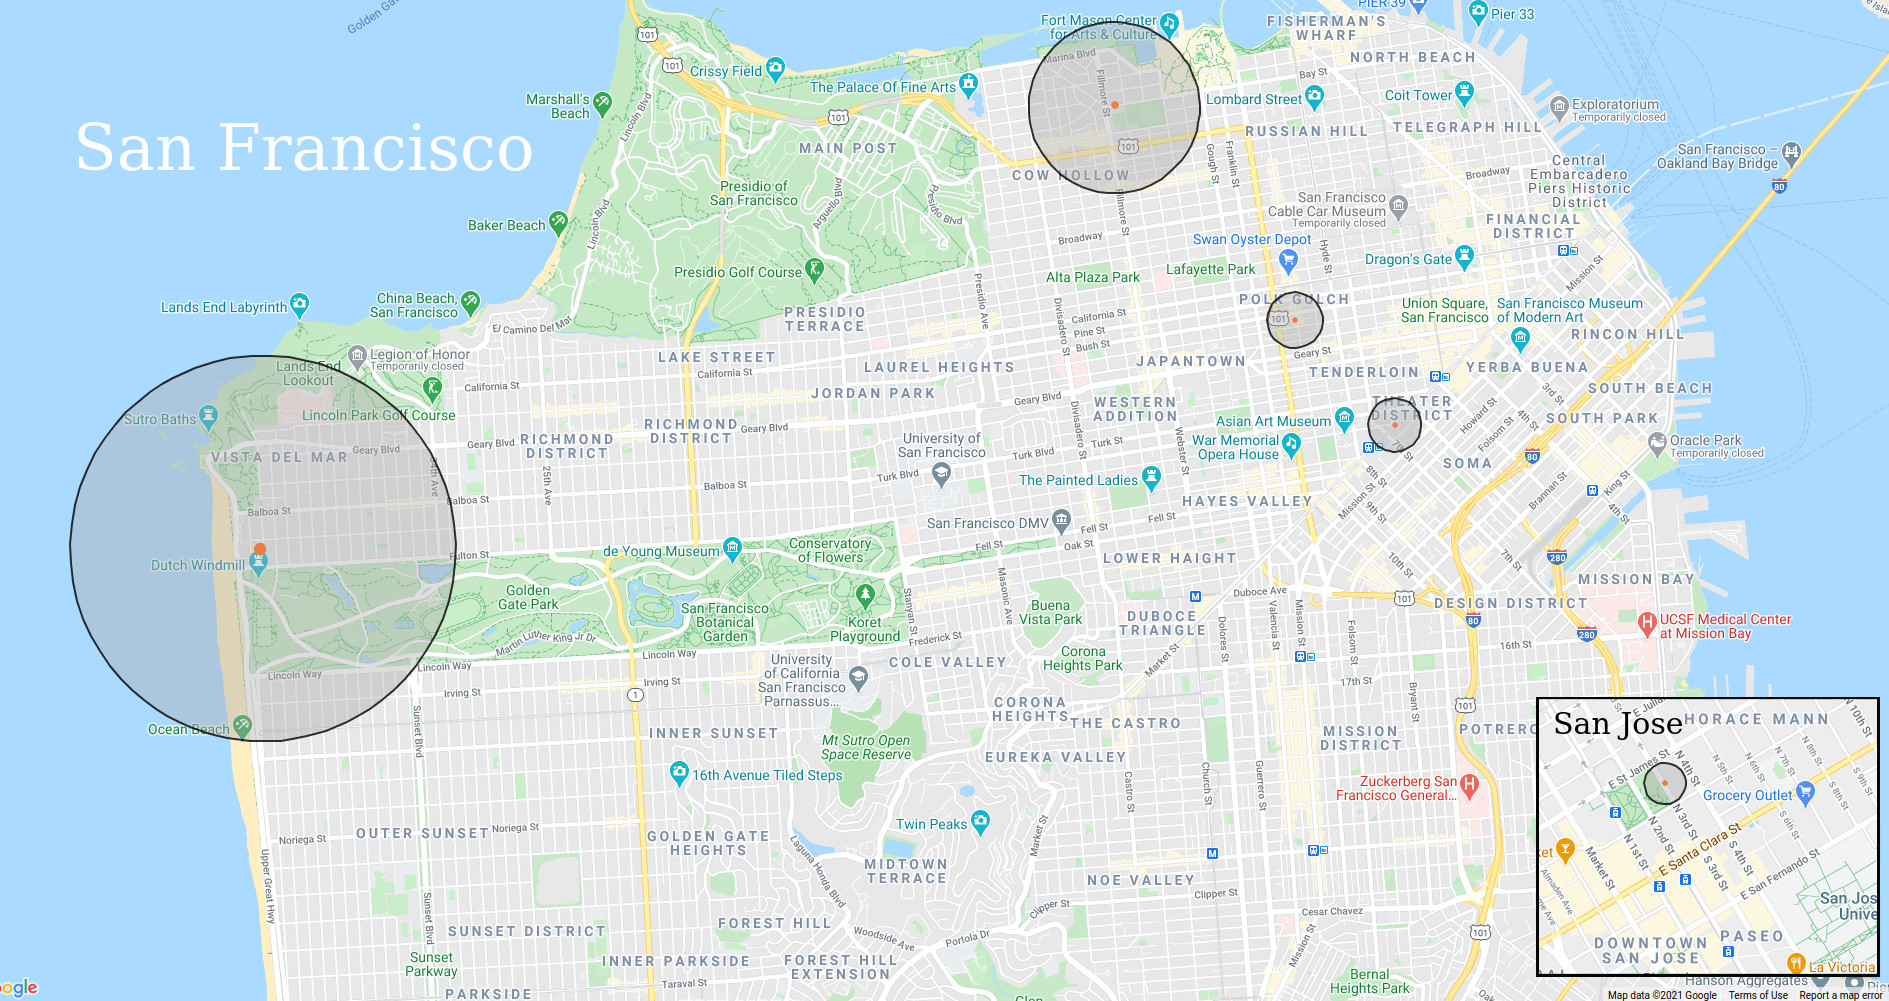

In [9]:
Image(filename='data/undocked_sf.jpg') 

In [ ]:
# Undocked stations table

undocked_df = ch[ch['closest_dist'] > 0]

undocked_df = undocked_df[['closest_id', 'closest_dist']]

# can sort by count or by mean, just change argument in sort_values()
undocked_df = undocked_df.groupby('closest_id').agg(['mean', 'count']).sort_values(('closest_dist', 'count'), ascending=False)

undocked_df.merge(grab_geo('CH'), left_index=True, right_index=True)

Running the same information for Chicago, we can make another [map](https://www.mapdevelopers.com/draw-circle-tool.php?circles=%5B%5B288.02%2C41.7999774%2C-87.5901747%2C%22%23AAAAAA%22%2C%22%23000000%22%2C0.4%5D%2C%5B166.78%2C41.7916323%2C-87.599791%2C%22%23AAAAAA%22%2C%22%23000000%22%2C0.4%5D%2C%5B242.8%2C41.7880507%2C-87.5884139%2C%22%23AAAAAA%22%2C%22%23000000%22%2C0.4%5D%2C%5B108.23%2C41.799263%2C-87.6008759%2C%22%23AAAAAA%22%2C%22%23000000%22%2C0.4%5D%2C%5B159.79%2C41.8909715%2C-87.6318562%2C%22%23AAAAAA%22%2C%22%23000000%22%2C0.4%5D%5D) of the top five *almost* docked stations and average distances.

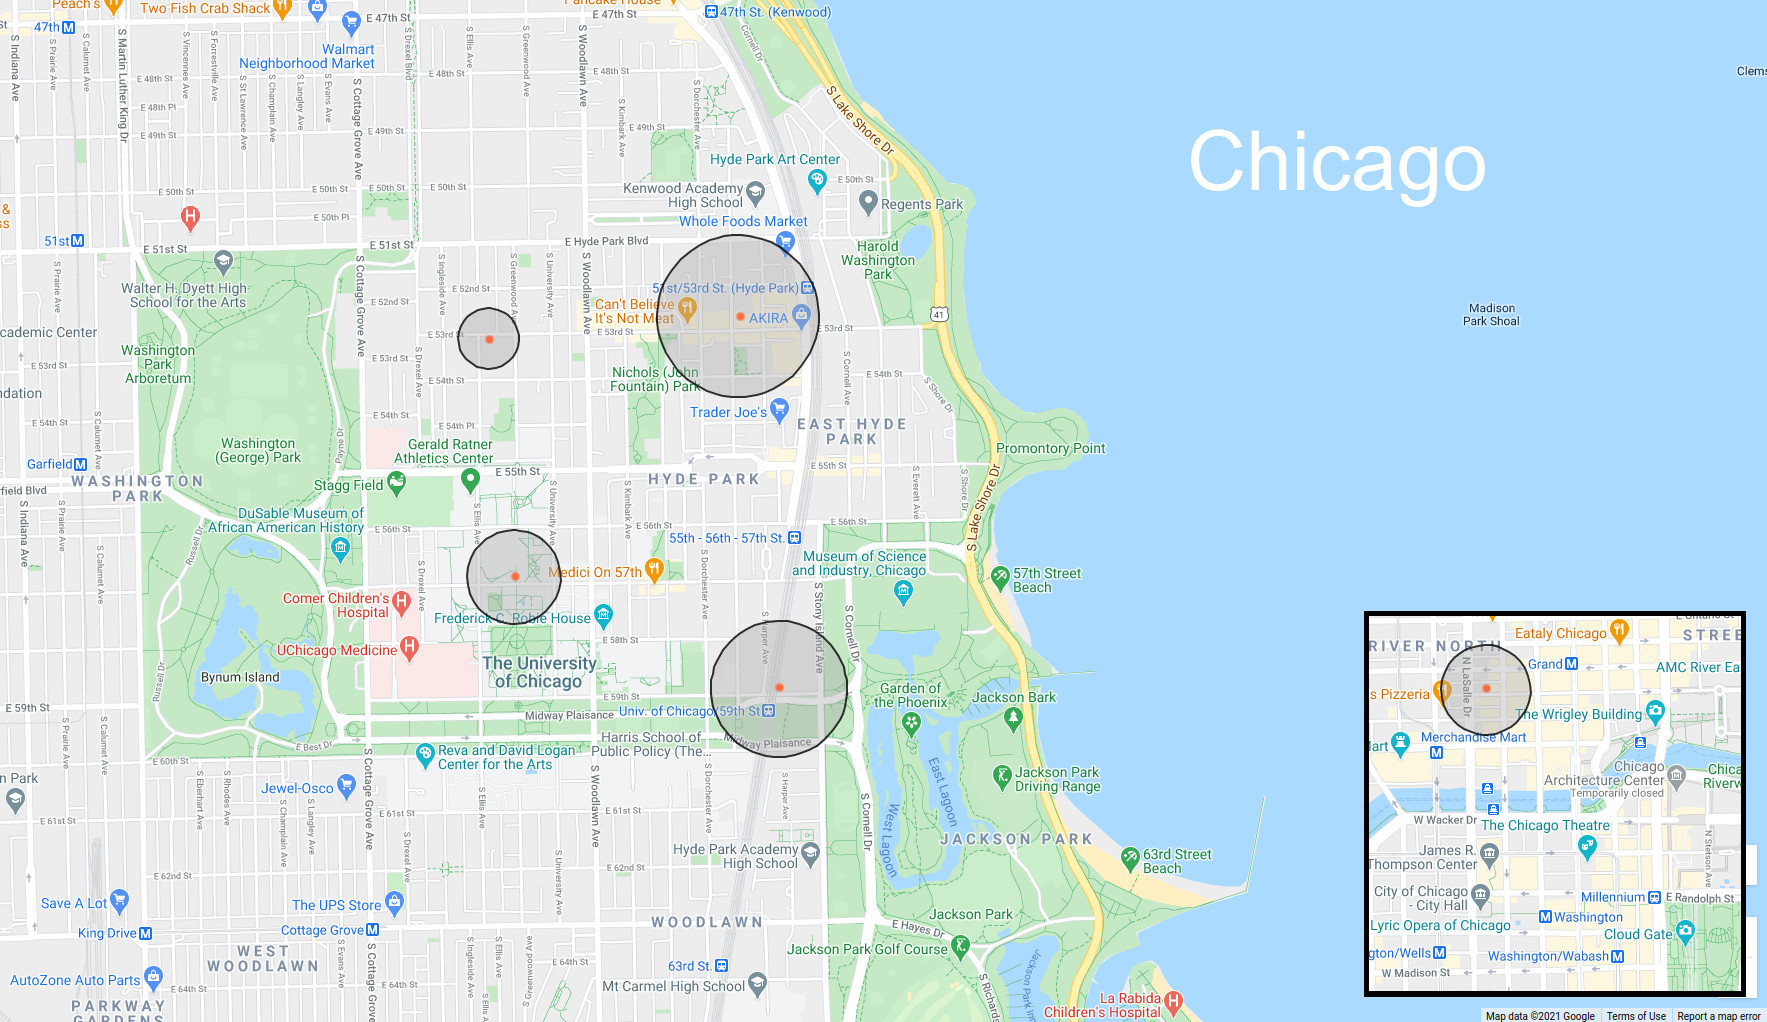

In [10]:
Image(filename='data/undocked_ch.jpg') 